In [187]:
import pandas as pd
import random

class Empresa:
    def __init__(self, nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem):
        self.nome = nome
        self.receita = receita
        self.propaganda = propaganda
        self.num_vendedores = num_vendedores
        self.salario_vendedores = salario_vendedores
        self.hora_extra = hora_extra
        self.estocagem = estocagem

    def calcular_despesas(self):
        salario_total = self.num_vendedores * self.salario_vendedores
        custo_hora_extra = self.hora_extra if self.hora_extra is not None else 0
        custo_estocagem = self.estocagem if self.estocagem is not None else 0

        despesas = {
            "Propaganda": self.propaganda,
            "Salário Vendedores": salario_total,
            "Hora Extra": custo_hora_extra,
            "Estocagem": custo_estocagem
        }

        return despesas

    def calcular_cmv(self):
        return 0.2 * self.receita

    def calcular_despesas_fixas(self):
        return {
            "Salários": 0.08 * self.receita,
            "Aluguel": 2000
        }

    def calcular_total_despesas(self):
        despesas = self.calcular_despesas()
        despesas_fixas = self.calcular_despesas_fixas()

        total_despesas = sum(despesas.values()) + sum(despesas_fixas.values())
        return total_despesas

    def calcular_resultado(self):
        return self.receita - self.calcular_cmv() - self.calcular_total_despesas()

    def esta_falida(self):
        return self.calcular_resultado() < 0

class SimuladorEmpresas:
    def __init__(self, num_empresas):
        self.empresas = []
        self.num_empresas = num_empresas
        self.resultados = []  # Store results here

    def criar_empresas_aleatorias(self):
        for i in range(self.num_empresas):
            nome = f"Empresa {i+1}"
            receita = random.uniform(1000, 100000)  # Random revenue
            propaganda = random.uniform(1000, 10000)  # Random advertising expenses
            num_vendedores = random.randint(5, 20)  # Random number of employees
            salario_vendedores = random.uniform(1320, 4000)  # Random employee salaries
            hora_extra = random.uniform(50, 100)  # Random overtime costs
            estocagem = random.uniform(500, 3000)  # Random storage costs

            empresa = Empresa(nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem)
            self.empresas.append(empresa)

    def calcular_e_exibir_resultados(self):
        self.resultados = []  # Reset the results
        data = {
            "Empresa": [],
            "Receita de vendas (faturamento)": [],
            "Propaganda": [],
            "Vendedores": [],
            "Salário Vendedores": [],
            "Hora Extra": [],
            "Estocagem": [],
            "CMV (custo da merc. Vendida)": [],
            "Salários": [],
            "Aluguel": [],
            "Total despesas": [],
            "Resultado": [],
            "Classificação": [],
        }
        
        for empresa in self.empresas:
            data["Empresa"].append(empresa.nome)
            data["Receita de vendas (faturamento)"].append(empresa.receita)
            data["Propaganda"].append(empresa.propaganda)
            data["Vendedores"].append(empresa.num_vendedores)
            data["Salário Vendedores"].append(empresa.salario_vendedores)
            data["Hora Extra"].append(empresa.hora_extra)
            data["Estocagem"].append(empresa.estocagem)
            data["CMV (custo da merc. Vendida)"].append(empresa.calcular_cmv())
            data["Salários"].append(empresa.calcular_despesas_fixas()["Salários"])
            data["Aluguel"].append(empresa.calcular_despesas_fixas()["Aluguel"])
            data["Total despesas"].append(empresa.calcular_total_despesas())
            resultado = empresa.calcular_resultado()
            self.resultados.append(resultado)
            data["Resultado"].append(resultado)
        
        classificacao = sorted(enumerate(self.resultados, start=1), key=lambda x: x[1])
        classificacao_final = {empresa[0]: i for i, empresa in enumerate(classificacao, start=1)}
        
        data["Classificação"] = [classificacao_final[i] for i in range(1, self.num_empresas + 1)]

        df = pd.DataFrame(data)
        display(df)

    def plotar_grafico(self):
        data = {
            "Empresa": [empresa.nome for empresa in self.empresas],
            "Resultado": self.resultados,  
            "Status": ["Falida" if empresa.esta_falida() else "Ativa" for empresa in self.empresas]
        }
        df = pd.DataFrame(data)

        plt.figure(figsize=(self.num_empresas + 2, 6))
        sns.barplot(x="Empresa", y="Resultado", hue="Status", data=df)
        plt.title("Resultados das Empresas")
        plt.xlabel("Empresa")
        plt.ylabel("Resultado")
        plt.show()


,Empresa,Receita de vendas (faturamento),Propaganda,Vendedores,Salário Vendedores,Hora Extra,Estocagem,CMV (custo da merc. Vendida),Salários,Aluguel,Total despesas,Resultado,Classificação
0,Empresa 1,37276.236385,5338.686895,20,2964.274824,90.981123,1052.276847,7455.247277,2982.098911,2000,70749.540258,-40928.551151,2
1,Empresa 2,93137.877639,2978.211581,7,3237.848492,91.544970,624.663489,18627.575528,7451.030211,2000,35810.389693,38699.912419,10
2,Empresa 3,25839.863662,1729.197321,14,3225.735759,56.176842,2151.411282,5167.972732,2067.189093,2000,53164.275169,-32492.384239,3
3,Empresa 4,90598.564598,5147.966561,20,3039.611232,65.045268,2951.330150,18119.712920,7247.885168,2000,78204.451790,-5725.600112,5
4,Empresa 5,73226.257080,6322.876018,11,3851.686584,57.043326,2546.691819,14645.251416,5858.100566,2000,59153.264151,-572.258488,7
5,Empresa 6,27814.613232,1897.904161,19,3833.953757,73.023435,2095.532463,5562.922646,2225.169059,2000,81136.750500,-58885.059915,1
6,Empresa 7,58621.012256,8615.770172,14,2094.626134,58.800482,1621.680844,11724.202451,4689.680980,2000,46310.698348,586.111457,9
7,Empresa 8,12289.208837,1420.200123,5,1327.043563,85.643377,1849.361889,2457.841767,983.136707,2000,12973.559909,-3142.192840,6
8,Empresa 9,72542.329646,2380.171504,19,2444.529242,61.035711,1810.287886,14508.465929,5803.386372,2000,58500.937078,-467.073362,8
9,Empresa 10,68083.726698,4858.460662,19,3714.178133,85.576132,2825.239936,13616.745340,5446.698136,2000,85785.359390,-31318.378031,4


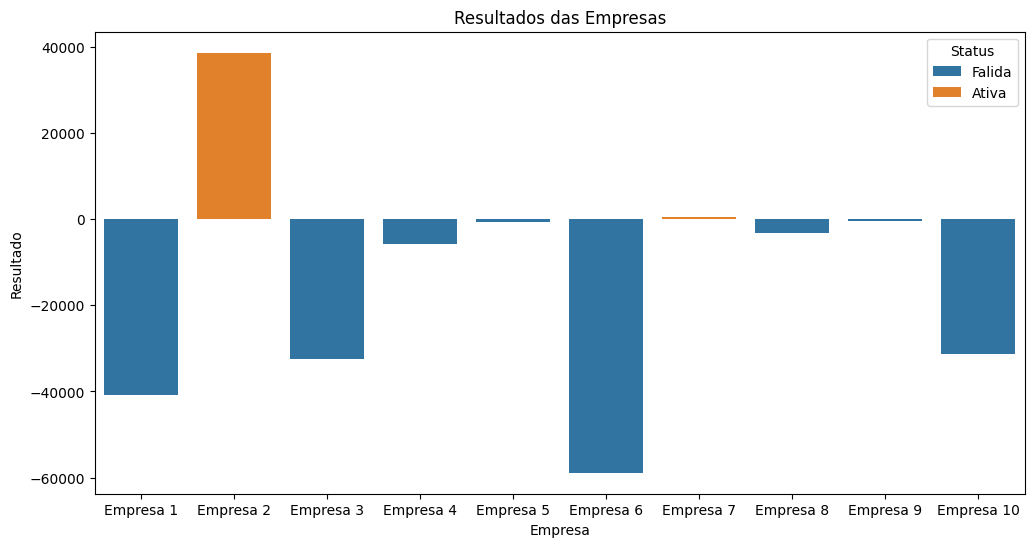

In [188]:
simulador = SimuladorEmpresas(num_empresas=10)
simulador.criar_empresas_aleatorias()
simulador.calcular_e_exibir_resultados()
simulador.plotar_grafico()
